## 自建数据生成器

In [1]:
import glob

# real_list  = glob.glob(r".\images\1/*.png")
# glitch_list = glob.glob(r".\images\0/*png")

real_list  = glob.glob(r".\hotdog\train\hotdog/*.png")
glitch_list = glob.glob(r".\hotdog\train\not-hotdog/*png")

list_img = real_list+glitch_list

print(len(real_list), len(glitch_list))

1000 1000


In [2]:
import cv2
import numpy as np
import pprint as pp

def get_batch(img_list, label_list, batch_size=8, show=False):
    # 在方法中需要用while写成死循环，因为每个step不会重新调用方法
    while True:
        index = np.random.choice(range(len(img_list)), batch_size)
        batch_list = [img_list[i] for i in index]
        batch_row = [cv2.imread(img) for img in batch_list]
        batch_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in batch_row]
        batch_matrix = [cv2.resize(i,(224, 224),interpolation=cv2.INTER_CUBIC) for i in batch_gray]
        batch_label = [label_list[i] for i in index]
        if show:
            pp.pprint(list(zip(batch_list, batch_label)))
        batch_matrix = np.concatenate(np.expand_dims(batch_matrix, axis=0), axis=0).astype(float)
        batch_label = np.array(batch_label)
        # batch_matrix = np.expand_dims(batch_matrix, -1)
        batch_matrix = (batch_matrix).astype(int)/255.
        yield batch_matrix, batch_label# , batch_list


list_lab = np.zeros([len(list_img), 2], dtype=int)
list_lab[:len(real_list), 0] = 1  # real: [1, 0]
list_lab[len(real_list):, 1] = 1  # fake: [0, 1]
b = next(get_batch(list_img, list_lab, show=True))

[('.\\hotdog\\train\\hotdog\\476.png', array([1, 0])),
 ('.\\hotdog\\train\\hotdog\\249.png', array([1, 0])),
 ('.\\hotdog\\train\\hotdog\\59.png', array([1, 0])),
 ('.\\hotdog\\train\\not-hotdog\\317.png', array([0, 1])),
 ('.\\hotdog\\train\\hotdog\\304.png', array([1, 0])),
 ('.\\hotdog\\train\\not-hotdog\\708.png', array([0, 1])),
 ('.\\hotdog\\train\\hotdog\\31.png', array([1, 0])),
 ('.\\hotdog\\train\\not-hotdog\\562.png', array([0, 1]))]


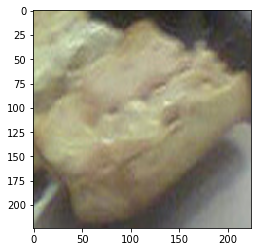

In [3]:
import matplotlib.pyplot as plt
num = np.random.randint(0, len(b))
img = (b[0][num]*255).astype(np.uint8) 
plt.imshow(img)
plt.show()
# print(b[2][num])
# pp.pprint(list(zip(b[1][:], b[2][:])))

## API数据生成器

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# train_datagen=ImageDataGenerator(rescale=1./255)
# train_flow=train_pic_gen.flow_from_directory(r'./hotdog\train',target_size=(128, 128),batch_size=32,class_mode='categorical')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_flow = train_datagen.flow_from_directory(
        r'./hotdog\train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='categorical')

Found 2000 images belonging to 2 classes.


## 网络定义

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense,Flatten,Dropout 
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications import InceptionV3


# model = Sequential()
# model.add(Conv2D(32, 3, 3, input_shape=(224, 224, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
 
# model.add(Conv2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
 
# model.add(Conv2D(64, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())# this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2))
# model.add(Activation('sigmoid'))

model = Sequential()
model.add(InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3)))
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='sigmoid'))
 
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
# top_model.load_weights(top_model_weights_path)
# add the model on top of the convolutional base
model.add(top_model)
for layer in model.layers[:25]:
    layer.trainable = Fals

model.summary()

NameError: name 'Fals' is not defined

## 训练

In [ ]:
from keras import losses
import keras.backend as K
from keras import optimizers
from keras.callbacks import TensorBoard

samples_per_epoch = len(list_img)
batch_size = 32

# K.set_value(sgd.lr, 0.5 * K.get_value(sgd.lr))
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit_generator(# train_flow,  
                    get_batch(list_img, list_lab),
                    steps_per_epoch=len(real_list)+len(glitch_list)//batch_size, # samples_per_epoch//batch_size, 
                    epochs=5,
                    shuffle=True,
                    callbacks=[TensorBoard(log_dir='./tmp/log', write_graph=True)])
# model.fit(img, label, batch_size=8, epochs=10)
model.save('model.h5')

# 测试
须将下面两个路径替换为测试图片的路径：
```
test_real_list  = glob.glob("./0/*.jpg")
test_glitch_list = glob.glob("./1/*jpg")
```

In [ ]:
import matplotlib.pyplot as plt

test_real_list  = glob.glob("./0/*.jpg")
test_glitch_list = glob.glob("./1/*jpg")
test_list_img = test_real_list + test_glitch_list

img_test = [cv2.imread(i) for i in test_list_img]
img_test = [cv2.resize(i,(300, 300),interpolation=cv2.INTER_CUBIC)
            for i in img_test]
img_test = np.concatenate(np.expand_dims(img_test, axis=0), axis=0)/255

label_test = np.zeros([len(img_test), 2], dtype=int)
label_test[:len(test_real_list), 0] = 1
label_test[len(test_real_list):, 1] = 1
pp.pprint(list(zip(test_list_img, label_test)))

In [9]:
import keras.models as KM

model = KM.load_model('model.h5')
result = model.evaluate(img_test, label_test)
pp.pprint(list(zip(model.metrics_names, result)))

42/42 [==============================] - 1s 13ms/step
[('loss', 0.009871753686595531), ('acc', 1.0)]


In [10]:
pre = model.predict(img_test)
print("预测标签：\n", np.argmax(pre, axis=1))
print("真实标签：\n", np.argmax(label_test, axis=1))

预测标签：
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
真实标签：
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


In [41]:
from sklearn import metrics

y = np.argmax(label_test, axis=1)
score = pre[range(pre.shape[0]), np.argmax(label_test, axis=1)]
pp.pprint(list(zip(y, score)))
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y, score)

[(0, 0.91748685),
 (0, 0.8434264),
 (0, 0.71841836),
 (0, 0.99005353),
 (0, 0.9734812),
 (0, 0.85615987),
 (0, 0.7994415),
 (0, 0.937271),
 (0, 0.90934694),
 (0, 0.9775279),
 (0, 0.9701817),
 (0, 0.91748685),
 (0, 0.99020946),
 (0, 0.9828389),
 (0, 0.737379),
 (0, 0.9608069),
 (0, 0.9851811),
 (0, 0.9827461),
 (0, 0.9070398),
 (0, 0.83348036),
 (0, 0.8754506),
 (1, 0.89990515),
 (1, 0.97451246),
 (1, 0.9760715),
 (1, 0.98225075),
 (1, 0.91044843),
 (1, 0.9496888),
 (1, 0.95403475),
 (1, 0.9653396),
 (1, 0.9828079),
 (1, 0.99164915),
 (1, 0.86353743),
 (1, 0.86725944),
 (1, 0.8124357),
 (1, 0.9959021),
 (1, 0.8706969),
 (1, 0.98835796),
 (1, 0.9869997),
 (1, 0.9700751),
 (1, 0.9692811),
 (1, 0.9679224),
 (1, 0.99854183)]


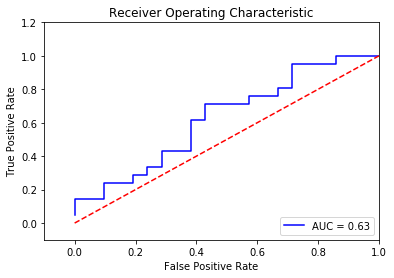

In [42]:
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
false_positive_rate, true_positive_rate

(array([0.        , 0.        , 0.0952381 , 0.0952381 , 0.19047619,
        0.19047619, 0.23809524, 0.23809524, 0.28571429, 0.28571429,
        0.38095238, 0.38095238, 0.42857143, 0.42857143, 0.47619048,
        0.57142857, 0.57142857, 0.66666667, 0.66666667, 0.71428571,
        0.71428571, 0.85714286, 0.85714286, 1.        ]),
 array([0.04761905, 0.14285714, 0.14285714, 0.23809524, 0.23809524,
        0.28571429, 0.28571429, 0.33333333, 0.33333333, 0.42857143,
        0.42857143, 0.61904762, 0.61904762, 0.71428571, 0.71428571,
        0.71428571, 0.76190476, 0.76190476, 0.80952381, 0.80952381,
        0.95238095, 0.95238095, 1.        , 1.        ]))

#### 多分类下ROC画法
每种类别下，都可以得到m个测试样本为该类别的概率（矩阵P中的列）。所以，根据概率矩阵P和标签矩阵L中对应的每一列，可以计算出各个阈值下的假正例率（FPR）和真正例率（TPR），从而绘制出一条ROC曲线。这样总共可以绘制出n条ROC曲线。最后对n条ROC曲线取平均，即可得到最终的ROC曲线。


In [44]:
def roc_gen(threshold = 0.9, class_id = 0):
    tp_row = np.intersect1d(np.where(pre[:, class_id]>=threshold), np.where(label_test[:, class_id]==1))
    fp_row = np.intersect1d(np.where(pre[:, class_id]>=threshold), np.where(label_test[:, class_id]==0))
    tn_row = np.intersect1d(np.where(pre[:, class_id] <threshold), np.where(label_test[:, class_id]==0))
    fn_row = np.intersect1d(np.where(pre[:, class_id] <threshold), np.where(label_test[:, class_id]==1))
    tp, fp, tn, fn = (float(len(s)) for s in (tp_row, fp_row, tn_row, fn_row))

    # 假阳性率 FPR = FP / (FP + TN)
    fpr = fp / (fp + tn)
    # 真阳性率 TPR = TP / (TP+FN)
    tpr = tp / (tp + fn)
    return fpr, tpr

thres = np.linspace(0, 1, 101)
FPR_0 = np.empty([101])
TPR_0 = np.empty([101])
FPR_1 = np.empty([101])
TPR_1 = np.empty([101])
for i, t in enumerate(thres):
    FPR_0[i], TPR_0[i] = roc_gen(t, 0)
    FPR_1[i], TPR_1[i] = roc_gen(t, 1)
FPR = (FPR_0 + FPR_1)/2
TPR = (TPR_0 + TPR_1)/2

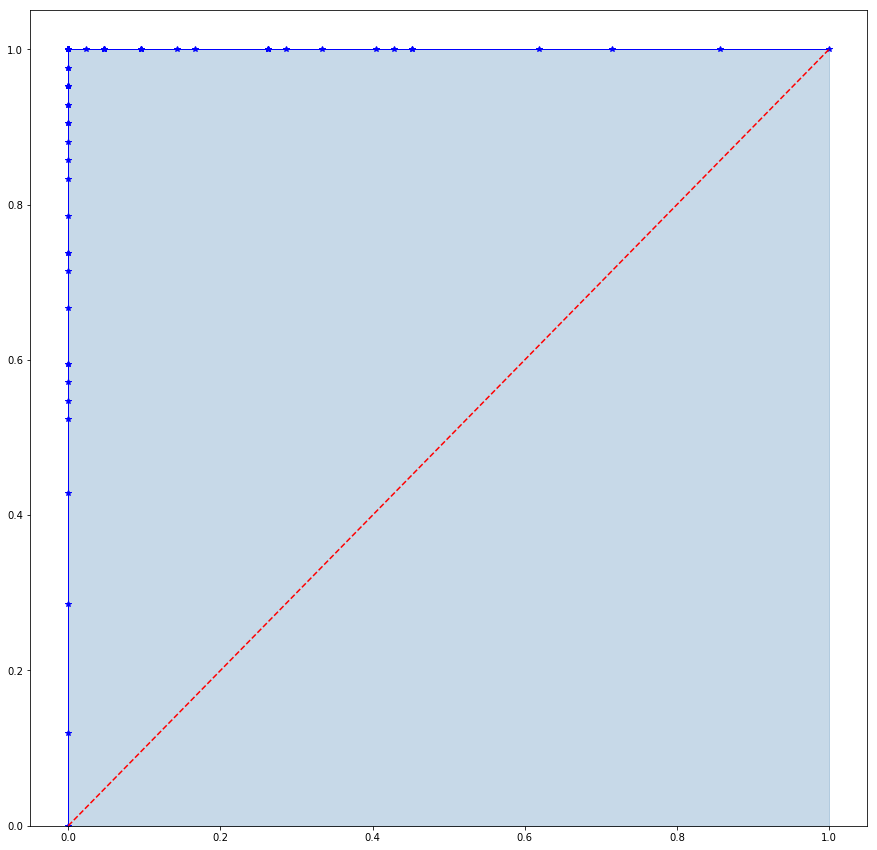

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15, 15])
# ACU面积
plt.stackplot(FPR, TPR, color='steelblue', alpha = 0.3, edgecolor = 'black')
plt.plot(FPR, TPR, "-*",color='blue', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.show()

In [1]:
import numpy as np
from sklearn.metrics import roc_curve

y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = roc_curve(y, scores, pos_label=2)